# Short-term COVID-19 daily cases prediction using LSTM


The present notebook comprises loading the preprocessed data (see `EDA.ipynb`) and **training the model**. <br>
Google Colab's free GPU was used for computation (~ 1 hour).

In [26]:
! nvidia-smi

Fri Mar 26 15:46:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    24W /  75W |    445MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Imports, loading the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('../data/COVID-19-Poland-preprocessed.csv')
df.set_index('day', inplace = True)
df.head()

,cases,recovered,tests,hospitalized,quaran,supervised
day,,,,,,
2020-10-04,-433.0,-0.169849,-0.777418,-0.725196,-0.045921,-0.170547
2020-10-05,72.0,-0.291918,0.516995,0.498107,0.005186,-0.384652
2020-10-06,230.0,-0.092515,1.902842,-0.403274,-0.699526,0.351302
2020-10-07,767.0,0.231840,-0.030738,-0.863623,0.761977,0.375501
2020-10-08,1277.0,-0.158052,-1.324570,-0.441905,0.462450,1.041227


### Target variable normalization (for better learning process interpretability)

In [4]:
scaler = StandardScaler()
scaler.fit(df['cases'].to_numpy().reshape(-1, 1))

cases = df['cases'].to_numpy() # unnormed cases might be useful later
df['cases_norm'] = scaler.transform(df['cases'].to_numpy().reshape(-1, 1))
df.drop(columns = ['cases'], inplace = True)
df.head()

,recovered,tests,hospitalized,quaran,supervised,cases_norm
day,,,,,,
2020-10-04,-0.169849,-0.777418,-0.725196,-0.045921,-0.170547,-0.392945
2020-10-05,-0.291918,0.516995,0.498107,0.005186,-0.384652,-0.159952
2020-10-06,-0.092515,1.902842,-0.403274,-0.699526,0.351302,-0.087055
2020-10-07,0.231840,-0.030738,-0.863623,0.761977,0.375501,0.160702
2020-10-08,-0.158052,-1.324570,-0.441905,0.462450,1.041227,0.396002


### Getting data ready for training

Based on: [YouTube](https://www.youtube.com/watch?v=gSYiKKoREFI)

In [5]:
n_future = 9 # number of days to predict cases for
n_past = 14 # number of days that prediction will rely on

In [6]:
# need an array representation
data = df.to_numpy()

X = []
y = []

for i in range(n_past, data.shape[0] - n_future + 1):
    X.append(data[i - n_past : i]) # X = [data[0 : 14], data[1 : 15], ...]
    y.append(data[i + n_future - 1, 0]) # y = [data[20, 0], data[21, 0], ...]

X, y = np.array(X), np.array(y)

In [7]:
X.shape, y.shape

((26, 14, 6), (26,))

`X.shape` = (no. samples, no. steps per sample, no. feautures)

### Model defining & training using grid search 

The dataset is pretty small, hence NN should be rather simple. In this particular case using **grid search might be a good idea on account of very quick training process** (based on idea from [this article](https://machinelearningmastery.com/how-to-grid-search-deep-learning-models-for-time-series-forecasting/)). <br>
Hyperparameters to be tuned:
* dropout rate;
* layer size;
* learning rate;
* kernel regularization parameter;
* recurrent regularization parameter.

In [8]:
param_grid = {
    'dropout' : [0.1, 0.2, 0.3, 0.4],
    'no_units' : [16, 32, 64],
    'lr' : [0.001, 0.01],
    'ker_reg' : [0.001, 0.01],
    'rec_reg' :  [0.001, 0.01]
}

In [9]:
# using list comprehension to get all the possible configs
possible_configs = [(d, u, l, k, r) 
  for d in param_grid['dropout'] 
  for u in param_grid['no_units'] 
  for l in param_grid['lr']
  for k in param_grid['ker_reg']
  for r in param_grid['rec_reg']]

for config in possible_configs:
  print(config)

(0.1, 16, 0.001, 0.001, 0.001)
(0.1, 16, 0.001, 0.001, 0.01)
(0.1, 16, 0.001, 0.01, 0.001)
(0.1, 16, 0.001, 0.01, 0.01)
(0.1, 16, 0.01, 0.001, 0.001)
(0.1, 16, 0.01, 0.001, 0.01)
(0.1, 16, 0.01, 0.01, 0.001)
(0.1, 16, 0.01, 0.01, 0.01)
(0.1, 32, 0.001, 0.001, 0.001)
(0.1, 32, 0.001, 0.001, 0.01)
(0.1, 32, 0.001, 0.01, 0.001)
(0.1, 32, 0.001, 0.01, 0.01)
(0.1, 32, 0.01, 0.001, 0.001)
(0.1, 32, 0.01, 0.001, 0.01)
(0.1, 32, 0.01, 0.01, 0.001)
(0.1, 32, 0.01, 0.01, 0.01)
(0.1, 64, 0.001, 0.001, 0.001)
(0.1, 64, 0.001, 0.001, 0.01)
(0.1, 64, 0.001, 0.01, 0.001)
(0.1, 64, 0.001, 0.01, 0.01)
(0.1, 64, 0.01, 0.001, 0.001)
(0.1, 64, 0.01, 0.001, 0.01)
(0.1, 64, 0.01, 0.01, 0.001)
(0.1, 64, 0.01, 0.01, 0.01)
(0.2, 16, 0.001, 0.001, 0.001)
(0.2, 16, 0.001, 0.001, 0.01)
(0.2, 16, 0.001, 0.01, 0.001)
(0.2, 16, 0.001, 0.01, 0.01)
(0.2, 16, 0.01, 0.001, 0.001)
(0.2, 16, 0.01, 0.001, 0.01)
(0.2, 16, 0.01, 0.01, 0.001)
(0.2, 16, 0.01, 0.01, 0.01)
(0.2, 32, 0.001, 0.001, 0.001)
(0.2, 32, 0.001, 0.001, 0

Since, in this case, NN might be prone to particular initialization **I will run the training 5 times for each configuration and then pick the best one**. <br>
Let's define necessary functions first.

In [10]:
# define model building and training function with particular parameters 
def build_train_model(dropout, no_units, lr, ker_reg, rec_reg):
  # building part
  model = Sequential([
      # first layer
      LSTM(units = no_units, kernel_regularizer = l2(ker_reg), recurrent_regularizer = l2(rec_reg),
                return_sequences = True, input_shape = (n_past, X.shape[2])),
      Dropout(dropout),

      # second layer
      LSTM(units = no_units, kernel_regularizer = l2(ker_reg), recurrent_regularizer = l2(rec_reg),
                return_sequences = False),
      Dropout(dropout),

      # output layer
      Dense(units = 1, activation = 'linear')
  ])

  model.compile(optimizer = Adam(learning_rate = lr), loss = 'mean_squared_error')

  # training part - using large number of epochs with early stopping for convenience
  es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-10, patience = 10, verbose = 0)
  history = model.fit(X, y, 
                      shuffle = False, epochs = 300, callbacks = [es], 
                      validation_split = 0.2, verbose = 0, batch_size = X.shape[0])
  
  return model, history

In [11]:
def evaluate_config(config): # pick the best run for a particular configuration
  min_loss = 1000

  for _ in range(5):
    model, history = build_train_model(*config)

    if min(history.history['val_loss']) < min_loss:
      min_loss = min(history.history['val_loss'])
      best_model = model
      best_history = history

  return best_model, best_history, min_loss

In [12]:
def pick_best_model(possible_configs): # does the grid search and returns the best model
  min_loss = 1000

  for i, config in enumerate(possible_configs):
    model, history, loss = evaluate_config(config) # returns the best model for current config

    if(loss < min_loss):
      min_loss = loss
      best_model = model
      best_history = history
      best_config = config

    print(f'{i+1} configs checked, current min_loss = {min_loss}')

  print('Best config:')
  print(f'Dropout: {best_config[0]}')
  print(f'No. of units: {best_config[1]}')
  print(f'Learning rate: {best_config[2]}')
  print(f'Kernel regularization: {best_config[3]}')
  print(f'Recurrent regularization: {best_config[4]}')

  return best_model, best_history

In [13]:
model, history = pick_best_model(possible_configs)

1 configs checked, current min_loss = 2.3285956382751465
2 configs checked, current min_loss = 2.3285956382751465
3 configs checked, current min_loss = 2.110929489135742
4 configs checked, current min_loss = 2.110929489135742
5 configs checked, current min_loss = 2.049184799194336
6 configs checked, current min_loss = 2.049184799194336
7 configs checked, current min_loss = 1.8724225759506226
8 configs checked, current min_loss = 1.8724225759506226
9 configs checked, current min_loss = 1.8724225759506226
10 configs checked, current min_loss = 1.8724225759506226
11 configs checked, current min_loss = 1.8724225759506226
12 configs checked, current min_loss = 1.8724225759506226
13 configs checked, current min_loss = 1.8724225759506226
14 configs checked, current min_loss = 1.8724225759506226
15 configs checked, current min_loss = 1.5765787363052368
16 configs checked, current min_loss = 1.5765787363052368
17 configs checked, current min_loss = 1.5765787363052368
18 configs checked, current

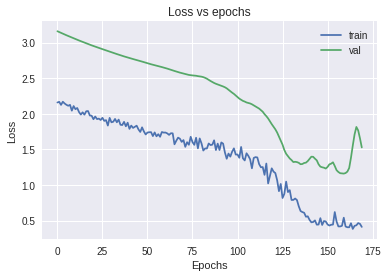

In [14]:
# learning curves for the best model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc = 'upper right')

plt.show()

### Calculating undiffed prediction (predicted new daily cases for next 9 days)

In [17]:
preds = model.predict(X[-n_future : ])

In [18]:
preds = scaler.inverse_transform(preds) # denormalizing

In [19]:
# undifferencing
x, x_diff = np.array([25221]).reshape(-1, 1), preds # hardcoded 25221 is a first true label undiffed value
preds_inversed = np.r_[x, x_diff].cumsum().astype(int)

In [20]:
preds_inversed[1 : ] # these are the predicted NEW DAILY cases for next 9 days

array([24633, 26838, 28951, 26205, 25069, 26852, 24802, 25168, 26669])

### Results visualization (using daily differences)

In [21]:
preds_days = df.index.tolist()
preds_days = preds_days[-preds.shape[0] : ]
df_preds = pd.DataFrame(data = preds, index = preds_days, columns = ['cases_pred'])

In [22]:
df_preds

,cases_pred
2020-11-12,-587.034241
2020-11-13,2204.250000
2020-11-14,2113.248779
2020-11-15,-2746.458252
2020-11-16,-1135.912231
2020-11-17,1783.215210
2020-11-18,-2049.604248
2020-11-19,365.938477
2020-11-20,1500.538330


In [25]:
df['cases'] = cases

trace1 = go.Scatter({
    'x': df.index,
    'y': df['cases'],
    'name': 'real cases diff.',
    'mode': 'lines'
})

trace2 = go.Scatter({
    'x': df_preds.index,
    'y': df_preds['cases_pred'],
    'name': 'predicted cases diff.',
    'mode': 'lines'
})

fig = make_subplots(specs = [[{'secondary_y': True}]], subplot_titles = ['Model predictions', ''])

fig.add_trace(trace1)
fig.add_trace(trace2, secondary_y = True)
fig.show()

**If you're on GitHub check out `images/plotly_prediction.png`. :)**

### Conclusions

* model is capable of predicting trend correctly although it overestimates a bit;
* using the data acquired since March worsens the performance (spring and autumn waves might be considered as separate phenomena on account of different magnitudes);
* inaccuracy occurs most likely as a result of too small training set for such type of model (according to our results, classic regression models like ARIMA seem to be the best choice for short-term prediction and lack of rich dataset).